<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/2.model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - CV
    - best_params_
    - Short list of models
    - sklearn.metrics module

# Imports

In [35]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [58]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [59]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [60]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [63]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils
import model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions
from sklearn_utils import print_model_cv_scores
from sklearn_utils import plot_cv_results
from sklearn_utils import fit_grid_search
from sklearn_utils import fit_randomized_search

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
from model import Model

# Setup paths

In [75]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [76]:
manager = PathManager(
    competition_path=COMPETITION_PATH, 
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_1 already exists


# Download the data

In [77]:
kaggle_test_path = os.path.join(
    manager.data_trial_path,
    'test_processed.csv'
)
df_test = pd.read_csv(
    kaggle_test_path, index_col=[0]
)
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.032819,-0.285964,-0.26814,-0.383325,-0.807152,-0.633614,-0.182156,-0.619713,-0.217343,-0.244523,...,-0.606797,-0.556056,-0.652386,2011.0,0.0,0.0,1.0,0.0,0.341412,0.693147
1,-0.334236,-0.285964,-0.26814,-0.383325,0.014161,-0.633614,-0.182156,-1.176974,-0.790338,-0.811816,...,-0.606797,-0.556056,-0.652386,2011.0,0.0,0.0,0.0,1.0,2.161000,0.693147


In [44]:
df_test_sample = pd.read_csv(
    os.path.join(manager.data_trial_path, 'test_sample_processed.csv'), 
    index_col=[0]
)
df_test_sample.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.032819,-1.653875,0.688913,-1.382555,-0.807152,-0.633614,-2.019553,-0.062452,-0.217343,-0.244523,...,-0.606797,-0.556056,-0.652386,2008.0,0.0,0.0,1.0,0.0,1.134031,14.842280
1,0.015056,0.397991,-0.268140,-1.382555,-0.807152,-0.159426,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,0.511872,2007.0,0.0,0.0,0.0,1.0,1.769000,15.312391


In [78]:
df_trainval = pd.read_csv(
    os.path.join(manager.data_trial_path, 'trainval_sample_processed.csv'), 
    index_col=[0]
)
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.334236,-0.285964,-1.225193,-0.383325,0.014161,-0.633614,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,1.094000,2009.0,0.0,0.0,0.0,1.0,2.069,15.278005
1,-0.683527,-0.285964,-1.225193,0.615905,1.656785,0.788952,-0.182156,-0.619713,-0.790338,-0.811816,...,-0.606797,-0.556056,-0.652386,2007.0,1.0,0.0,1.0,0.0,5.663,15.255171


In [79]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [80]:
X_test_sample = df_test_sample.values[:, :-1]  # test subsample from training data
Y_test_sample = df_test_sample.values[:, -1]

# Select and train models (+ ensemble methods)

## Define models

In [48]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {'n_estimators': [100, 200, 500]}
    ],

    [
        {
            'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
            'max_depth': [i for i in range(1, 20)]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'Elastic',
    [
        {
            'alpha': [0.1, 0.3, 0.5],
            'l1_ratio': [0.2, 0.4]
        }, 
    ],
    [
        {}
    ]
)

SVRModel = Model(
    SVR(),
    'SVM reg',
    [
        {}
    ],
    [
        {}
    ]
)

In [49]:
all_models = {
    model.name: model for model in [RFModel, SVRModel, ElasticNetModel]
}

## Preliminary look (shortlisting 2-5 models)

## Cross validation result

In [51]:
_ = print_model_cv_scores(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: SVM reg, mean: -0.23975755066794463, std: 0.10254520924351965
Model: Elastic, mean: -0.21569093211351922, std: 0.10074172443016455
Model: RF, mean: -0.1953351561772094, std: 0.06658129763421157


## Overfitting behavior

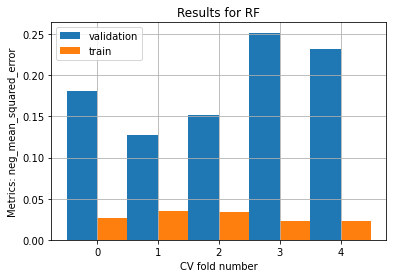

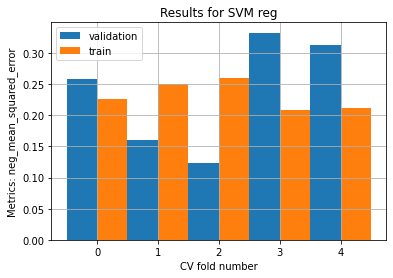

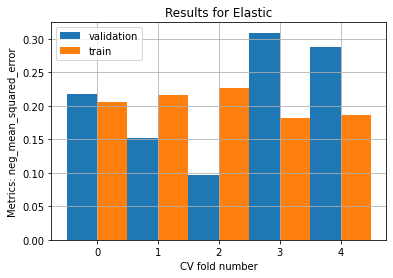

In [65]:
# %%pycodestyle
plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

In [66]:
shortlisted_models = {
    model.name: model for model in [RFModel, ElasticNetModel, SVRModel]
}

# Fine tuning

## Grid search

In [67]:
grid_search_results = fit_grid_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_ = 5,
    scoring_ = 'neg_mean_squared_error'
)

Fitting RF
Fitting Elastic
Fitting SVM reg


In [68]:
print(grid_search_results['RF'].best_params_)
print(grid_search_results['Elastic'].best_estimator_)

{'n_estimators': 100}
ElasticNet(alpha=0.5, l1_ratio=0.2)


## Randomized search

In [69]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    n_iter_=10,
    scoring_='neg_mean_squared_error'
)

Fitting RF
Fitting Elastic
Fitting SVM reg


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [70]:
print(rand_search_results['RF'].best_estimator_)
print(rand_search_results['SVM reg'].best_estimator_)

RandomForestRegressor(max_depth=17, n_estimators=800)
SVR()


# Check final models for overfit

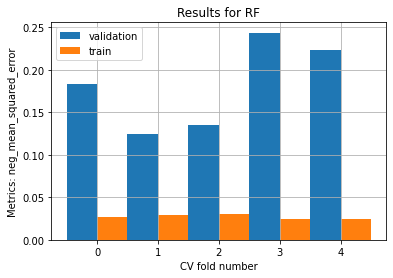

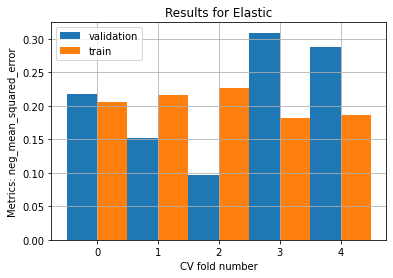

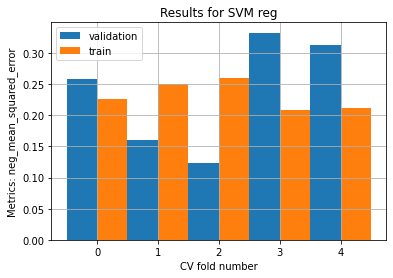

In [71]:
plot_cv_results(
    sklearn_models_dict_ = {
        name: rand_search_results[name].best_estimator_ \
        for name in rand_search_results.keys()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

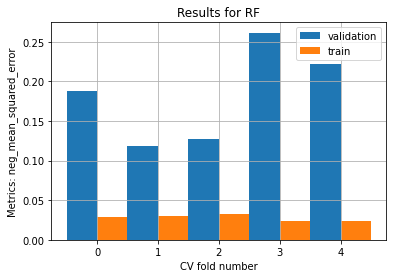

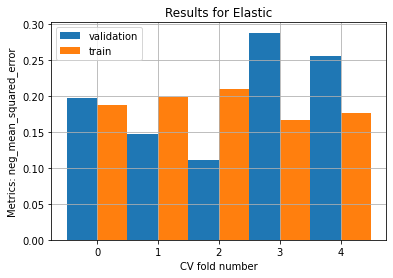

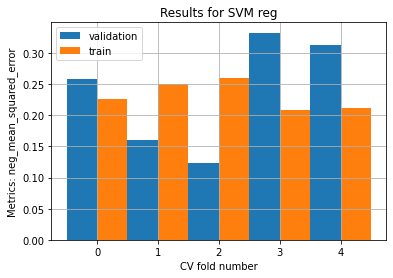

In [72]:
plot_cv_results(
    sklearn_models_dict_ = {
        name: grid_search_results[name].best_estimator_ \
        for name in grid_search_results.keys()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Saving fine tuned candidates (retrained on train+val subset)

In [81]:
manager.save_models(
    {
        model_name: result.best_estimator_
        for model_name, result in rand_search_results.items()
    }
)

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_1/RF already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_1/Elastic already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_1/SVM reg already exists
